In [1]:
import sys
sys.path.insert(0,'..')
import simulacra.star
import simulacra.tellurics
from simulacra.star import PhoenixModel

import random
import numpy as np

import astropy.io.fits
import astropy.time as at

import astropy.units as u
import astropy.coordinates as coord
import astropy.constants as const

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


<h1>02 - Now add a Tellurics model with atmospheric conditions</h1>

In [2]:
ra, dec = np.random.uniform(0,360) * u.degree, np.random.uniform(0,80) * u.degree
obs = 'APO'
loc = coord.EarthLocation.of_site(obs)
target = coord.SkyCoord(ra,dec,frame='icrs')

Functions from the star module can be used to select times to view a given star from some observatory.

In [3]:
tstart = at.Time('2020-01-01T08:10:00.123456789',format='isot',scale='utc')
tend   = tstart + 180 * u.day
night_grid = simulacra.star.get_night_grid(loc,tstart,tend,steps_per_night=5)
possible_times, airmass = simulacra.star.get_realistic_times(target,loc,night_grid)

In [4]:
epoches = 3

Now we selected some random sample of these to observe at and the airmasses at those times

In [5]:
obs_ints = random.sample(range(len(airmass)),epoches)
obs_times, obs_airmass = possible_times[obs_ints], airmass[obs_ints]

<h2>Tellurics Model</h2>
The tellurics model requires these airmasses at the time of observation. However each of the pressure, temperatures, and humidities can be set by the user after initialization. If a single value is passed that is used for every epoch. Or you can pass it an array of quantities of size equal to the number of epoches.

In [6]:
wave_min = 620*u.nm
wave_max = 630*u.nm
tellurics_model = simulacra.tellurics.TelFitModel(wave_min,wave_max,loc)

Define some atmospheric parameters for the tellurics. These can either be constant over all time or an array with the same length as the number of epoches.

In [7]:
tellurics_model.pressure    = np.random.uniform(870,880,epoches) * u.hPa
tellurics_model.humidity    = np.random.uniform(45.0,55.0,epoches)
tellurics_model.temperature = np.random.uniform(300,310,epoches) * u.Kelvin

<h2>Star Model</h2>
Here we define the star model with some temperature, distance, logg, and companion parameters. The logg, T, z, and alpha parameters must correspond to an appropriate atmosphere model from the PHOENIX libraray online. Then also give it some companion parameters that could affect its velocity. This is what we will be trying to find use jabble.

z is metallicity. And distance can be set to whatever you want.

In [8]:
logg = 1.0
T    = 4800
z    = -1.0
alpha= 0.4
distance  = 100 * u.pc
amplitude = 10 * u.m/u.s
period    = 7 * u.day
stellar_model = PhoenixModel(distance,alpha,z,T,logg,target,amplitude,period)

using saved wave file
../data/stellar/PHOENIX/lte04800-1.00-1.0.Alpha=+0.40.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
using saved flux file
reading in ../data/stellar/PHOENIX/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits


In [9]:
from simulacra.detector import Detector, spacing_from_res

<h2>Detector</h2>
Here we define our detector giving it an aperature area, resolution, dark current, read noise, and ccd efficiency. All of these can be except area can be given as an array of the same size as the wave_grid (eg. if the detector has varying resolution or noise levels)

In [10]:
resolution = 100_000.0
area = np.pi*(4.3 * u.m/2)**2
exp_times = 8 * np.ones(epoches)* u.minute 
dark_current = 1/u.s
read_noise   = 1
ccd_eff      = 0.99
through_put  = 0.05

epsilon = 1.0
w = 1.5

gamma = 1.0

delta_x = spacing_from_res(2*resolution)
x_grid = np.arange(np.log(wave_min.to(u.Angstrom).value),np.log(wave_max.to(u.Angstrom).value),delta_x)
wave_grid = np.exp(x_grid) * u.Angstrom

detector = Detector(stellar_model,resolution,loc,area,wave_grid,dark_current,read_noise,ccd_eff,through_put,gamma=gamma,epsilon=epsilon,w=w)

In [11]:
detector.add_model(tellurics_model)

<h2>Simulator</h2>
Now comes the bulk of the work, run the simulation with the given transmission models, star, detector at the given times for some exposure times.

In [12]:
data = detector.simulate(obs_times,exp_times)

surface flux: mean 1.31e+14 erg / (cm3 s)	 median 1.14e+14 erg / (cm3 s)
obs     flux: mean 3.78e-02 erg / (cm3 s)	 median 3.28e-02 erg / (cm3 s)
generating spectra...
humidity: 46.18774067708725
 pressure: 870.9631589494434
 temperature: 309.17582052825344
 lat: 32.78000000000001
 elevation: 2.797999999999601
 freqmin(cm-1): 15847.860538827257
 freqmax(cm-1): 16155.08885298869
 angle: 66.2082662400772

88483
humidity: 53.993939626736285
 pressure: 877.1042309831478
 temperature: 304.6395765004293
 lat: 32.78000000000001
 elevation: 2.797999999999601
 freqmin(cm-1): 15847.860538827257
 freqmax(cm-1): 16155.08885298869
 angle: 68.53704659463105

80009
humidity: 52.731124119453256
 pressure: 873.676557385425
 temperature: 305.7854636326953
 lat: 32.78000000000001
 elevation: 2.797999999999601
 freqmin(cm-1): 15847.860538827257
 freqmax(cm-1): 16155.08885298869
 angle: 66.98490763257885

80009
<simulacra.tellurics.TelFitModel object at 0x7fae6a4eccc0> [1.6178939059585673e-06, 2.1699551400

In [13]:
(14 * u.m**2 * 0.03 * u.Angstrom * 6300 * u.Angstrom * 8 * u.min * 324 * u.erg/(u.s*u.cm**3) /(const.hbar * const.c)).to(1)

<Quantity 1.30160505e+13>

Save file to pickle jar

In [14]:
outdir = ''
filename = '../out/data_e{}_R{}_a{}_p{}_l{:3.1e}{:3.1e}_ep{}_w{}_snr{:2.1e}'.format(epoches,resolution,\
                                                                amplitude.to(u.m/u.s).value,\
                                                                period.to(u.day).value,\
                                                                detector.lambmin.value,\
                                                                detector.lambmax.value,\
                                                               epsilon,w,np.mean(data['data']['snr_readout']))
print(filename)
data.to_pickle(filename + '.pkl')
data.to_h5(filename + '.h5')

../out/data_e3_R100000.0_a10.0_p7.0_l6.2e+036.3e+03_ep1.0_w1.5_snr1.3e+04
saving time
quantity
epoches  saving as string
quantity
quantity
quantity
quantity
quantity
quantity
quantity
flux  saving as string
wave  saving as string
quantity
quantity
quantity
alpha  saving as string
quantity
quantity
fluxname  saving as string
generate_spectra  saving as string
quantity
quantity
logg  saving as string
outdir  saving as string
quantity
plot  saving as string
plot_interpolated  saving as string
quantity
quantity
saving target...350.4367523211178 deg 18.249415109230355 deg
temperature  saving as string
quantity
quantity
wavename  saving as string
quantity
z  saving as string
quantity
quantity
quantity
_resolution  saving as string
quantity
a  saving as string
add_model  saving as string
quantity
checkmax  saving as string
checkmin  saving as string
convolve  saving as string
quantity
energy_to_photon  saving as string
epsilon  saving as string
gamma  saving as string
interpolate_data  saving

In [15]:
print(target)

<SkyCoord (ICRS): (ra, dec) in deg
    (350.43675232, 18.24941511)>


In [16]:
import matplotlib.pyplot as plt
import scipy.ndimage
def normalize(y,yerr,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y/y_low, yerr/y

1.66e+08 1.29e+04
1.66e+08 1.29e+04
1.66e+08 1.29e+04


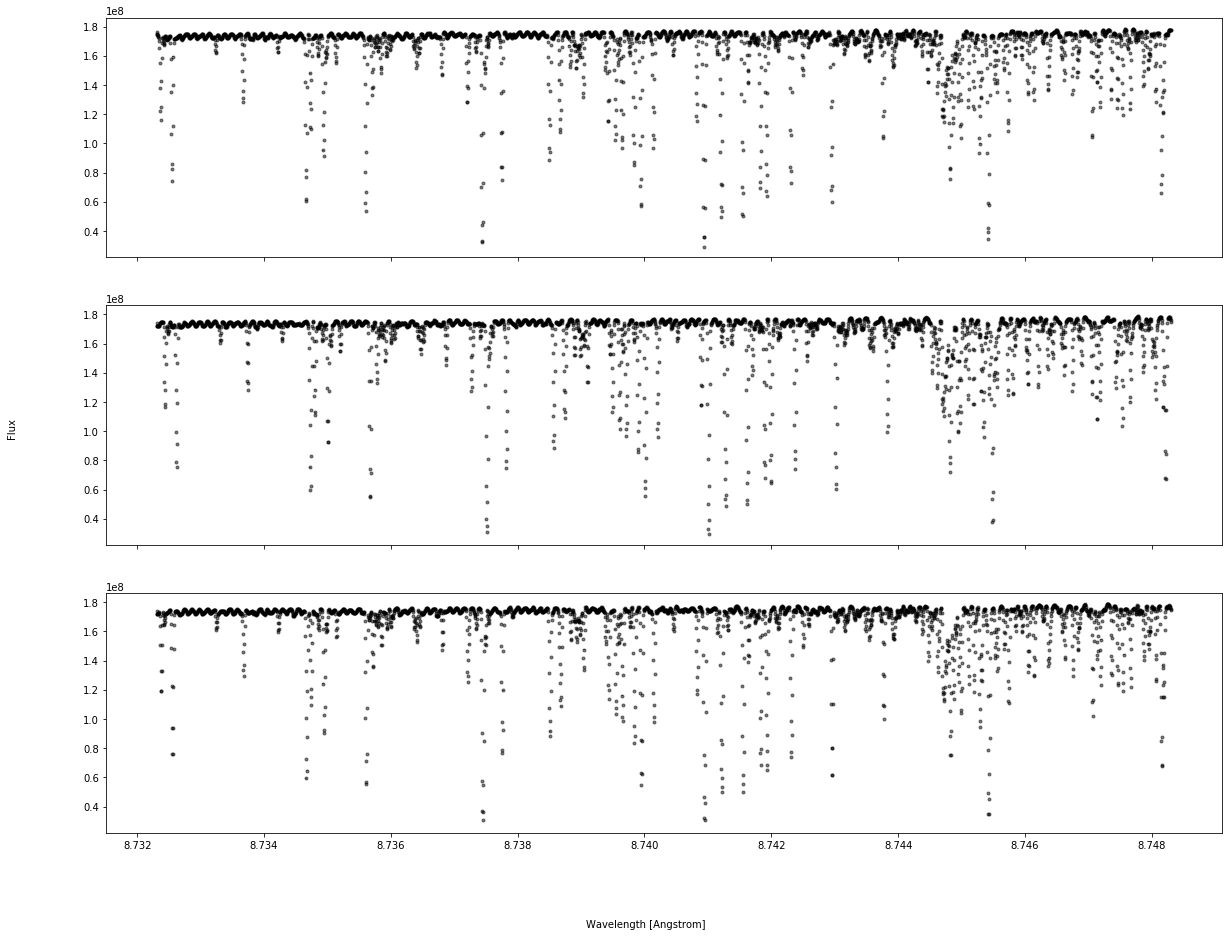

In [17]:
sigma = 200
n_plots = 3
plt_unit = u.Angstrom
sort_times = np.argsort(obs_times)
fig, axes = plt.subplots(n_plots,figsize=(20,5 * n_plots),sharex=True,sharey=True)

fig.text(0.5, 0.04, 'Wavelength [{}]'.format(plt_unit), ha='center', va='center')
fig.text(0.06, 0.5, 'Flux', ha='center', va='center', rotation='vertical')
for i in range(n_plots):
#     axes[i].set_xlim(np.log(6297),np.log(6300))
#     axes[i].set_ylim(-1.2,1.2)
    print('{:3.2e}'.format(np.mean(data['data']['flux'][i,:])),'{:3.2e}'.format(np.mean(data['data']['ferr'][i,:])))
    axes[i].errorbar(np.log(data['data']['wave'].to(u.Angstrom).value),data['data']['flux'][i,:],yerr=data['data']['ferr'][i,:],fmt='.k',alpha=0.5)
#     data.plot_data(axes[i],sort_times[i],xy='x',units=plt_unit)
#     data.plot_tellurics(axes[i],sort_times[i],xy='x',units=plt_unit)#,normalize=normalize,nargs=[sigma]
#     data.plot_gas(axes[i],sort_times[i],xy='x',units=plt_unit)
#     data.plot_theory(axes[i],sort_times[i],xy='x',units=plt_unit)
#     data.plot_lsf(axes[i],sort_times[i],xy='x',units=plt_unit)
#     data.plot_star(axes[i],sort_times[i],xy='x',units=plt_unit)
# plt.savefig('out/datatest5.png')
plt.show()

In [18]:
from simulacra.dataset import print_keys
print_keys(data)

data: <class 'dict'>
--obs_times: <class 'numpy.ndarray'>
--exp_times: <class 'astropy.units.quantity.Quantity'>
--epoches: <class 'int'>
--rvs: <class 'astropy.units.quantity.Quantity'>
--mask: <class 'numpy.ndarray'>
--flux_expected: <class 'astropy.units.quantity.Quantity'>
--flux: <class 'numpy.ndarray'>
--wave: <class 'astropy.units.quantity.Quantity'>
--snr_readout: <class 'numpy.ndarray'>
--ferr: <class 'numpy.ndarray'>
theory: <class 'dict'>
--star: <class 'dict'>
----deltas: <class 'astropy.units.quantity.Quantity'>
----flux: <class 'astropy.units.quantity.Quantity'>
----wave: <class 'astropy.units.quantity.Quantity'>
--interpolated: <class 'dict'>
----tellurics: <class 'dict'>
------flux: <class 'numpy.ndarray'>
----star: <class 'dict'>
------flux: <class 'numpy.ndarray'>
----total: <class 'dict'>
------flux: <class 'numpy.ndarray'>
------wave: <class 'astropy.units.quantity.Quantity'>
------mask: <class 'numpy.ndarray'>
--tellurics: <class 'dict'>
----flux: <class 'list'>
--

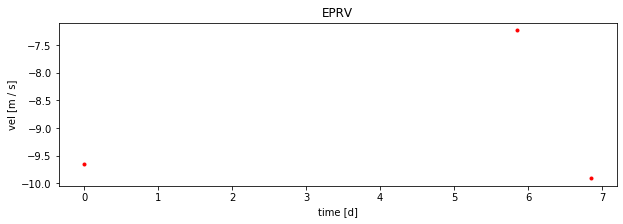

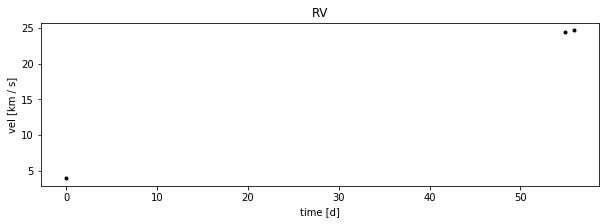

In [19]:
times = at.Time([obs_times[i] + exp_times[i]/2 for i in range(len(obs_times))])
rv = data['data']['rvs'].to(u.km/u.s)
bc  = target.radial_velocity_correction(obstime=times,location=loc).to(u.km/u.s)
eprv = rv - bc

plt.figure(figsize=(10,3))
plt.title('EPRV')
v_unit = u.m/u.s
plt.plot((times - min(times)).to(u.day).value % period.to(u.day).value,eprv.to(v_unit).value,'.r')
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

plt.figure(figsize=(10,3))
plt.title('RV')
v_unit = u.km/u.s
plt.plot((times - min(times)).to(u.day).value,rv.to(v_unit).value,'.k')
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()